In [1]:
# %% [imports and dataset loading]
# Required imports
from matminer.featurizers.structure import SiteStatsFingerprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from matminer.datasets import load_dataset
from pymatgen.core import Structure
import matplotlib.pyplot as plt  
import pickle

c:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
dataset = load_dataset("matbench_perovskites")
df = pd.DataFrame(dataset)
# Drop rows with missing values
df = df.dropna()
# Check the type of the first element in the 'structure' column
first_element = df['structure'].iloc[0]
print(f"Type of first element in 'structure' column: {type(first_element)}")

Type of first element in 'structure' column: <class 'pymatgen.core.structure.Structure'>


In [ ]:
# %% [Feature extraction]
from matminer.featurizers.site import OPSiteFingerprint
# Initialize the SiteStatsFingerprint featurizer with OPSiteFingerprint
site_featurizer = OPSiteFingerprint()
structure_featurizer = SiteStatsFingerprint(
    site_featurizer=site_featurizer,
    stats=('mean', 'std_dev', 'minimum', 'maximum')
)

# Featurize the 'structure' column with parallel processing
X = structure_featurizer.featurize_dataframe(df, 'structure')

SiteStatsFingerprint:  58%|█████▊    | 10920/18928 [23:01:21<1:13:20,  1.82it/s]    

In [ ]:
# Save featurized data for future use
with open('featurized_data.pickle', 'wb') as f:
    pickle.dump(X, f)

# Load featurized data
with open('featurized_data.pickle', 'rb') as f:
    X = pickle.load(f)

print("Featurized data has been loaded successfully.")

Featurized data has been loaded successfully.


In [ ]:
# %% [Target variable and train-test split]
y = dataset['e_form']  # Target variable: formation energy
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# %% [Check for missing or non-numeric columns]
# Check if all columns are numerical
print(X_train.dtypes)

structure               object
e_form                 float64
mean sgl_bd CN_1       float64
std_dev sgl_bd CN_1    float64
minimum sgl_bd CN_1    float64
                        ...   
maximum q4 CN_12       float64
mean q6 CN_12          float64
std_dev q6 CN_12       float64
minimum q6 CN_12       float64
maximum q6 CN_12       float64
Length: 150, dtype: object


In [ ]:
import numpy as np
# Identify columns with non-numeric or problematic data
non_numeric_columns = []
for col in X_train.columns:
    if isinstance(X_train[col].iloc[0], (list, np.ndarray)):
        non_numeric_columns.append(col)
    elif not np.issubdtype(X_train[col].dtype, np.number):
        non_numeric_columns.append(col)

In [ ]:
# Example of handling array-like columns (you can aggregate them)
for col in non_numeric_columns:
    print(f"Processing column: {col}")
    if isinstance(X_train[col].iloc[0], (list, np.ndarray)):
        X_train[f'{col}_mean'] = X_train[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
        X_train[f'{col}_max'] = X_train[col].apply(lambda x: np.max(x) if isinstance(x, (list, np.ndarray)) else x)
        X_train[f'{col}_min'] = X_train[col].apply(lambda x: np.min(x) if isinstance(x, (list, np.ndarray)) else x)

    # Drop the original array column after aggregation
    X_train = X_train.drop(columns=[col])

# Now your X_train should only contain numeric columns
print(X_train.dtypes)


Processing column: structure
e_form                 float64
mean sgl_bd CN_1       float64
std_dev sgl_bd CN_1    float64
minimum sgl_bd CN_1    float64
maximum sgl_bd CN_1    float64
                        ...   
maximum q4 CN_12       float64
mean q6 CN_12          float64
std_dev q6 CN_12       float64
minimum q6 CN_12       float64
maximum q6 CN_12       float64
Length: 149, dtype: object


In [ ]:
import numpy as np

# Identify columns with non-numeric or problematic data
non_numeric_columns = []
for col in X.columns:
    # Check if the column contains lists or arrays
    if isinstance(X[col].iloc[0], (list, np.ndarray)):
        non_numeric_columns.append(col)
    elif not np.issubdtype(X[col].dtype, np.number):
        non_numeric_columns.append(col)

# Aggregate array-like columns into numeric features
for col in non_numeric_columns:
    print(f"Processing column: {col}")
    if isinstance(X[col].iloc[0], (list, np.ndarray)):
        # Example: Aggregate using mean, max, and min
        X[f'{col}_mean'] = X[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
        X[f'{col}_max'] = X[col].apply(lambda x: np.max(x) if isinstance(x, (list, np.ndarray)) else x)
        X[f'{col}_min'] = X[col].apply(lambda x: np.min(x) if isinstance(x, (list, np.ndarray)) else x)

    # Drop the original non-numeric column
    X = X.drop(columns=[col])

# Verify that all columns are now numeric
print(X.dtypes)
print("All columns are now numeric!")


Processing column: structure
e_form                 float64
mean sgl_bd CN_1       float64
std_dev sgl_bd CN_1    float64
minimum sgl_bd CN_1    float64
maximum sgl_bd CN_1    float64
                        ...   
maximum q4 CN_12       float64
mean q6 CN_12          float64
std_dev q6 CN_12       float64
minimum q6 CN_12       float64
maximum q6 CN_12       float64
Length: 149, dtype: object
All columns are now numeric!


In [ ]:
# %% [Cross-validation implementation]
# Define the model (Random Forest Regressor)
model = RandomForestRegressor(random_state=42)

# Initialize K-Fold Cross-Validation (5 splits in this example)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation (using Mean Squared Error as scoring metric)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')  # Negative MSE for sklearn's cross_val_score

# Convert negative MSE to positive
cv_scores = -cv_scores

In [ ]:
# Display cross-validation results
print("Cross-Validation MSE Scores:", cv_scores)
print("Mean CV MSE:", cv_scores.mean())
print("Standard Deviation of CV MSE:", cv_scores.std())

# %% [Model training]
# Train the model on the entire dataset
model.fit(X_train, y_train)

# %% [Ensure consistent columns for testing]
# Ensure that X_test has the same columns as X_train
X_test = X_test[X_train.columns]

# %% [Predictions and Evaluation]
# Make predictions on both train and test sets
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

Cross-Validation MSE Scores: [2.10272583e-06 2.69004754e-06 2.20770523e-05 5.04324439e-06
 1.03155614e-06]
Mean CV MSE: 6.588925240387106e-06
Standard Deviation of CV MSE: 7.854715688934428e-06


Train MAE: 4.127592128040886e-05
Test MAE: 6.354992076258603e-05
Train RMSE: 0.0011946110228737165
Test RMSE: 0.0013534913082860825
Train R²: 0.9999973997295504
Test R²: 0.999996734175535


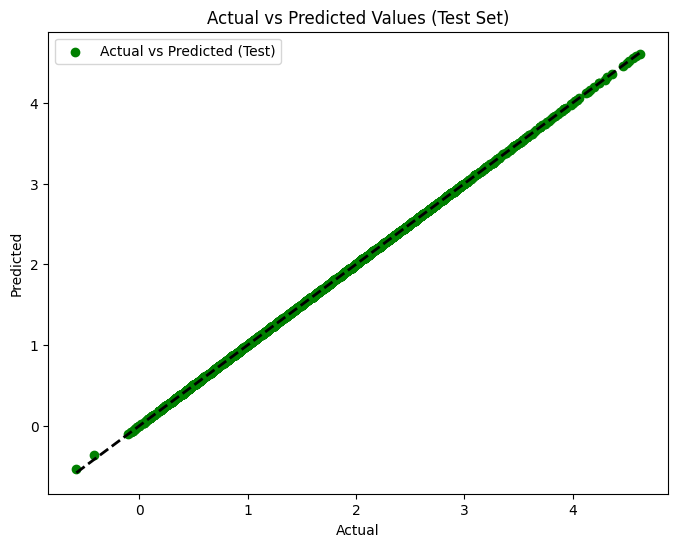

In [ ]:
# %% [Metrics: MAE, RMSE, R²]
# Evaluate the model
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_train)}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test))}")
print(f"Train R²: {r2_score(y_train, y_pred_train)}")
print(f"Test R²: {r2_score(y_test, y_pred_test)}")

# %% [Visualizations: Actual vs Predicted]
# Plotting actual vs predicted values for test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, color='green', label='Actual vs Predicted (Test)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Test Set)')
plt.legend()
plt.show()


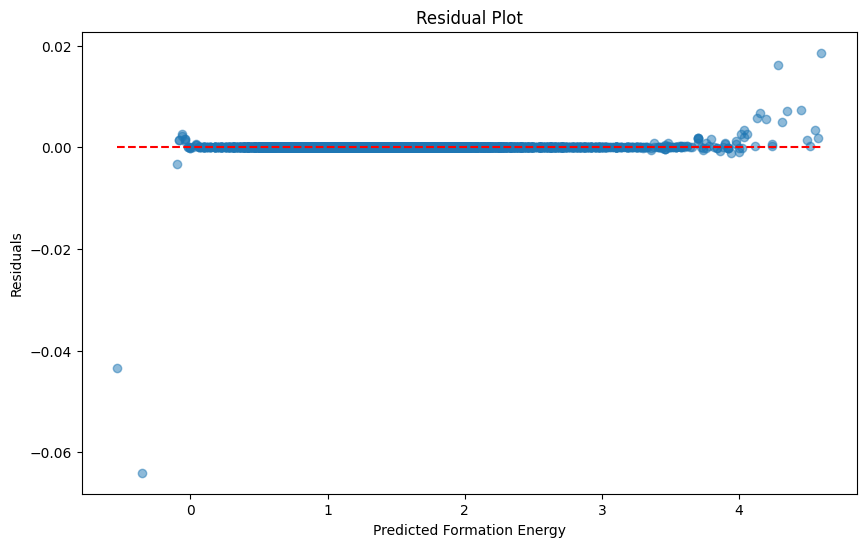

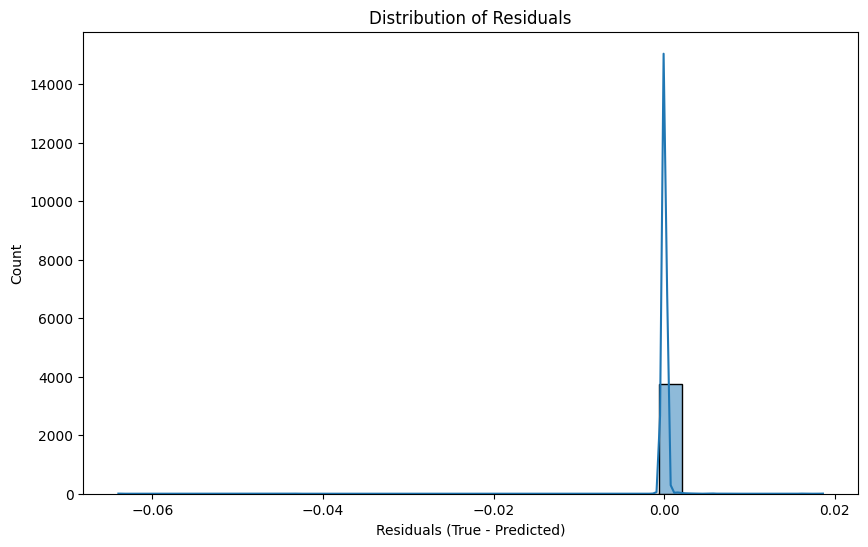

In [ ]:
import seaborn as sns
# %% [Residual Plot and Diagnostics]
# 1. Residual Plot
residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred_test), xmax=max(y_pred_test), colors='red', linestyles='--')
plt.xlabel('Predicted Formation Energy')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# 2. Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals (True - Predicted)')
plt.title('Distribution of Residuals')
plt.show()

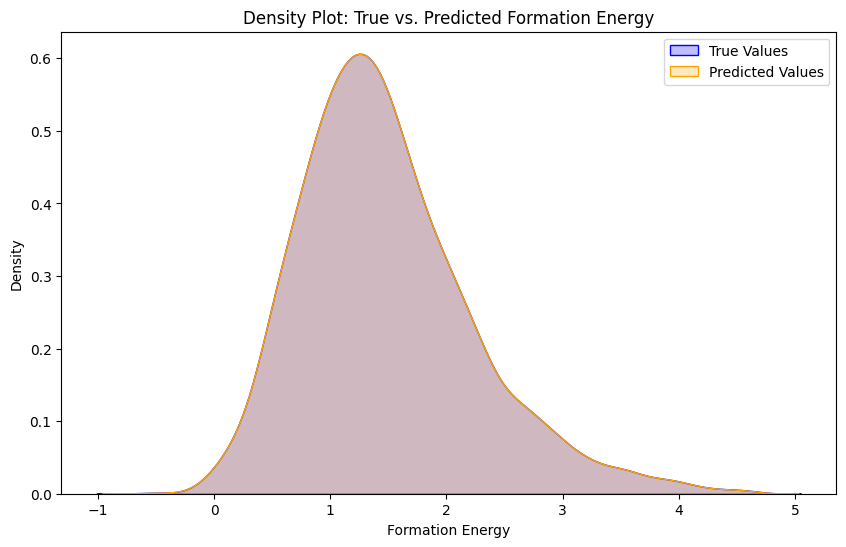

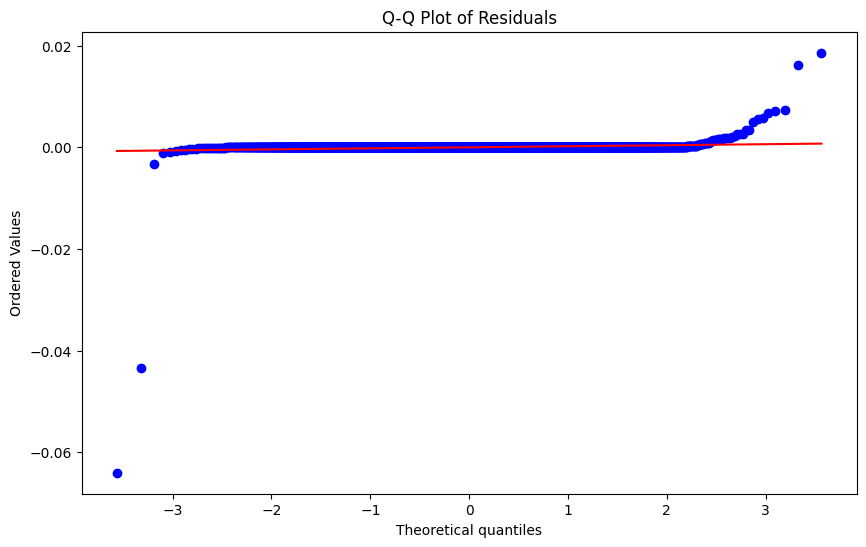

In [ ]:
# 3. Prediction Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='True Values', fill=True, color="blue")
sns.kdeplot(y_pred_test, label='Predicted Values', fill=True, color="orange")
plt.xlabel('Formation Energy')
plt.ylabel('Density')
plt.title('Density Plot: True vs. Predicted Formation Energy')
plt.legend()
plt.show()

# 4. Q-Q Plot (Quantile-Quantile Plot)
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

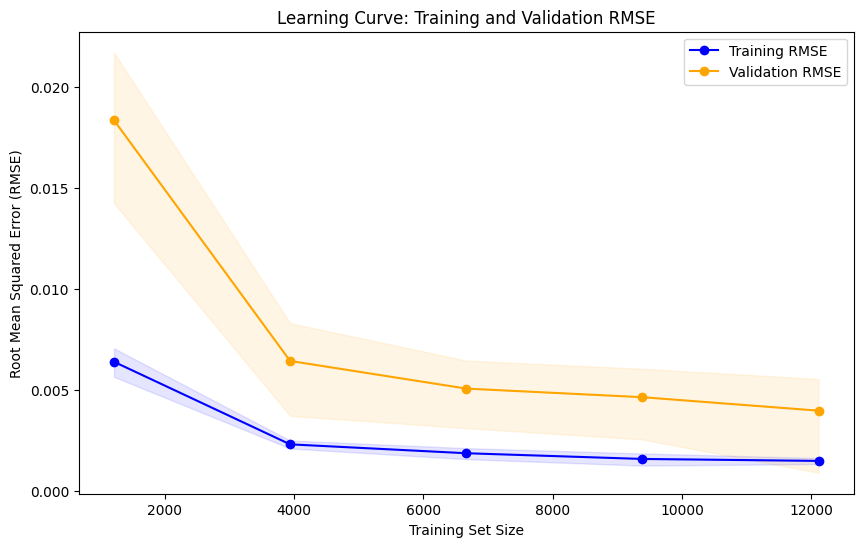

In [ ]:
# %% [Learning Curve]
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate mean and std of training and validation scores
train_scores_mean = np.mean(-train_scores, axis=1)
train_scores_std = np.std(-train_scores, axis=1)
test_scores_mean = np.mean(-test_scores, axis=1)
test_scores_std = np.std(-test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.sqrt(train_scores_mean), 'o-', color="blue", label="Training RMSE")
plt.plot(train_sizes, np.sqrt(test_scores_mean), 'o-', color="orange", label="Validation RMSE")
plt.fill_between(train_sizes, np.sqrt(train_scores_mean - train_scores_std),
                 np.sqrt(train_scores_mean + train_scores_std), color="blue", alpha=0.1)
plt.fill_between(train_sizes, np.sqrt(test_scores_mean - test_scores_std),
                 np.sqrt(test_scores_mean + test_scores_std), color="orange", alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Learning Curve: Training and Validation RMSE')
plt.legend()
plt.show()

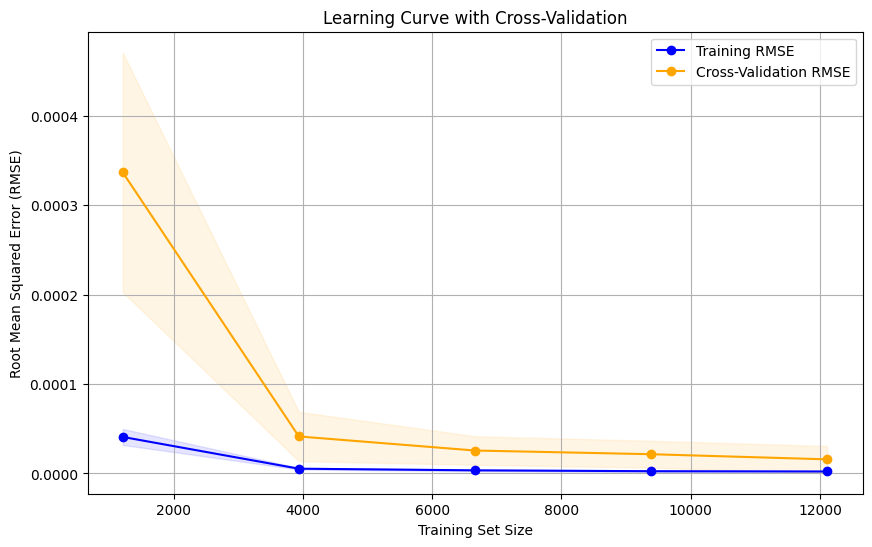

In [ ]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training RMSE")
plt.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="Cross-Validation RMSE")
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="orange")

plt.title("Learning Curve with Cross-Validation")
plt.xlabel("Training Set Size")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()
plt.grid()
plt.show()